In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import co2calc

## constants

In [3]:
R_earth = 6371e3 # m; earth radius
A_earth = 4. * np.pi * R_earth**2 # m^2; earth area
frac_lnd = 0.3 # fraction land area
frac_ocn = 1 - frac_lnd # fraction ocean area

A_ocn = A_earth * frac_ocn # m^2; ocean area
V_ocn = 1.292e18 # m^3; ocean volume

rho_ref = 1026.

µmolkg_to_mmolm3 = rho_ref * 1e-6 * 1e3
mmolm2_to_Pg = A_ocn * 12. * 1e-15 * 1e-3

## the model

Set up an analytical solution to a simple 2-box model.

![](https://www.researchgate.net/profile/Nicolas_Gruber/publication/267987399/figure/fig2/AS:337104748990465@1457383443794/Schematic-of-a-two-box-model-of-the-ocean-Both-the-surface-and-the-deep-boxes-are_W640.jpg)


The surface layer is assumed to be at equilibrium with atmospheric CO$_2$. 
Input paramters include:
- The height of each box
- The global alkalinity inventory
- Export flux
- The overturning circulation
- Temperature and salinity

In [4]:
# height
h = np.array([
    100., # surface
    3750., #V_ocn / A_ocn - 100. #deep
]) # m

Alk_inventory = 2500. * h.sum() # mmol/m^2
Psi_Sv = 20.
export_PgCyr = 12
S = 34.7
T = 12.

# The model
Psi = Psi_Sv * 1e6 # m^3/s
export = export_PgCyr / 365. / 86400. / 12. * 1e15 # mol/s

DIC = np.ones(2)
ALK = np.ones(2)

def two_box_ocean_equil(pCO2atm=284.7, rain_ratio=0.1):
    """compute analytical solution for 2 box ocean model"""
    ALK[0] = (Alk_inventory - export * rain_ratio * 2. * h[1] / Psi) / (h[1] + h[0])
    ALK[1] = (Alk_inventory - h[0] * ALK[0]) / h[1]

    
    DIC[0] = co2calc.co2sys(S, T, pCO2=pCO2atm, ALK=ALK[0]/µmolkg_to_mmolm3).DIC * µmolkg_to_mmolm3
    DIC[1] = DIC[0] + export / Psi

    return DIC, ALK

## sensitivity to rain ratio

Solve the for equilibrium over a range of rain ratios.

In [5]:
N = 100
dic = np.empty((N, 2))
alk = np.empty((N, 2))
rain_ratio = np.linspace(0.0, 0.9, N)
for i in range(N):
    dic[i, :], alk[i, :] = two_box_ocean_equil(rain_ratio=rain_ratio[i]) #rain_ratio[i])

reference alk surface: 2500.00 mmol/m^3
reference alk deep: 2500.00 mmol/m^3



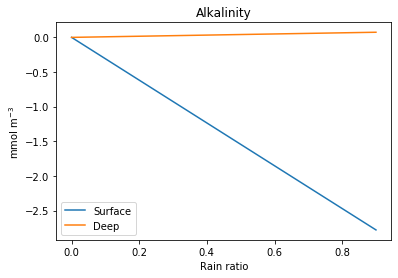

In [6]:
plt.plot(rain_ratio, alk[:, 0] - alk[0, 0], label='Surface')
plt.plot(rain_ratio, alk[:, 1] - alk[0, 1], label='Deep')
plt.title('Alkalinity')
plt.ylabel('mmol m$^{-3}$')
plt.xlabel('Rain ratio');
plt.legend()

print(f'reference alk surface: {alk[0, 0]:.2f} mmol/m^3');
print(f'reference alk deep: {alk[0, 1]:.2f} mmol/m^3\n');

reference inventory: 36470.45 Pg C



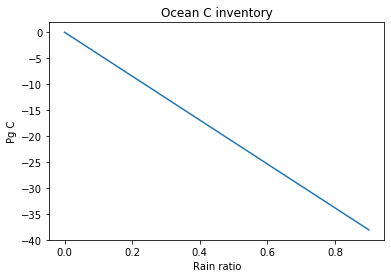

In [7]:
dic_inventory = (dic * h).sum(axis=1) * mmolm2_to_Pg # Pg

plt.plot(rain_ratio, dic_inventory - dic_inventory[0])
plt.title('Ocean C inventory')
plt.ylabel('Pg C')
plt.xlabel('Rain ratio');

print(f'reference inventory: {dic_inventory[0]:.2f} Pg C\n');